### 1.导入模块

In [1]:
# base 
import pandas as pd 
import numpy as np 

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# 绘图
import matplotlib.pylab as plt
import seaborn as sns

#一些参数风格设置
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set(style='ticks', context='poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

### 2.数据加载及预处理

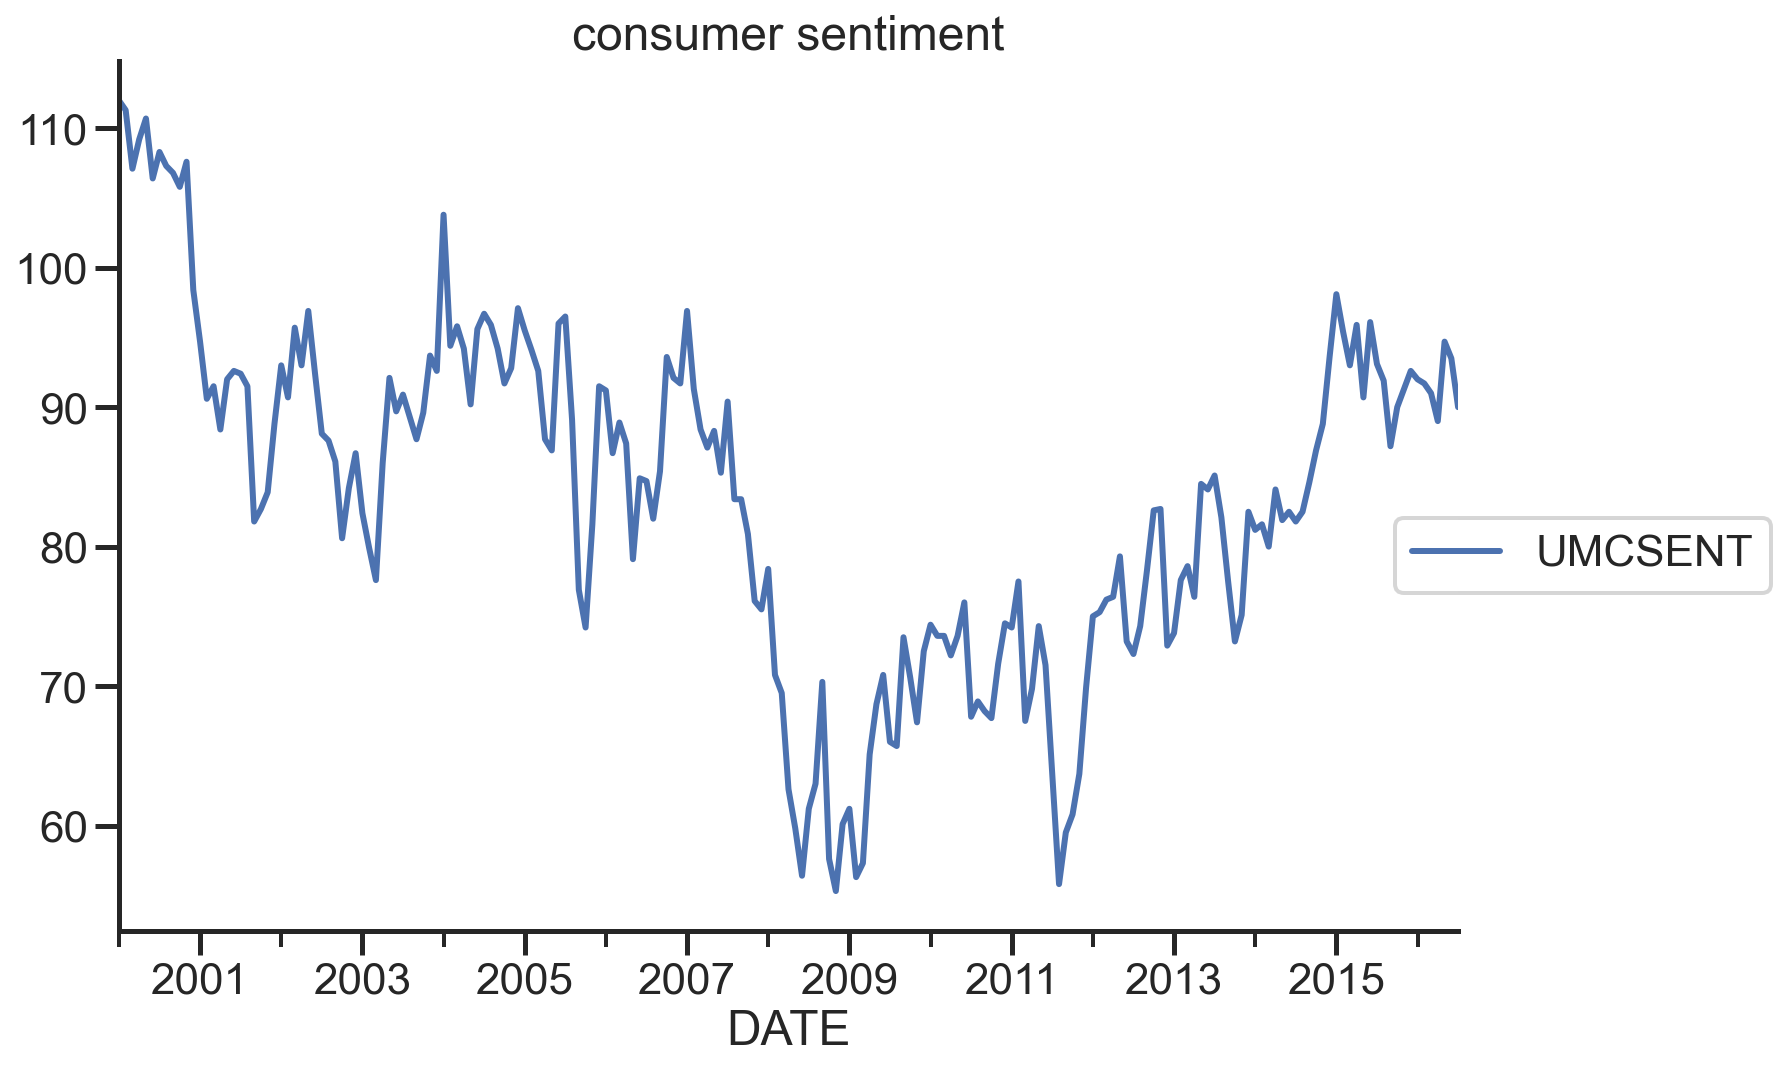

In [7]:
# 数据读取 
# index_col 和  parse_dates 用于指定索引列和时间解析的列， 可以写索引数字如0， 表示第1列，也可以写对应列的名称，名称大小写要一致 
# sentiment = pd.read_csv('./confidence美国消费者信心指数sentiment.csv', index_col=0, parse_dates=[0])
sentiment = pd.read_csv('./confidence美国消费者信心指数sentiment.csv', index_col='DATE', parse_dates=['DATE'])
# print(sentiment.head()) # 取前面5行数据
# print(sentiment.tail()) # 取末尾5行数据
# 切分为测试数据和训练数据
# 获取数据条数
n_sample = sentiment.shape[0] 
n_train = int(0.95*n_sample)+1
# iloc 只能接收整数索引，loc只能接收标签索引  效果是一样的
ts_train = sentiment.iloc[:n_train]['UMCSENT']
ts_test = sentiment.iloc[n_train+1:]['UMCSENT']

sentiment_short = sentiment.loc['2000':'2016']
#figsize 第一个是长，第二个是宽, 定义画布
sentiment_short.plot(figsize=(12,8))
plt.title('consumer sentiment')
#legend主要的作用就是解释一下我们坐标轴里面的图形的含义，后面那个坐标(1.25, 0.5)，就是将他的表示展示在我们的坐标轴边界的外部
plt.legend(bbox_to_anchor=(1.25,0.5))
# 默认去掉右边和上边框线
sns.despine()
#sns.despine(left=True) # 指定隐去左边框线
#sns.despine(right=True) # 指定隐去右边框线
plt.show()

### 3.差分项 d值确认

<ipython-input-21-23c7fc9c3fcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
<ipython-input-21-23c7fc9c3fcc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

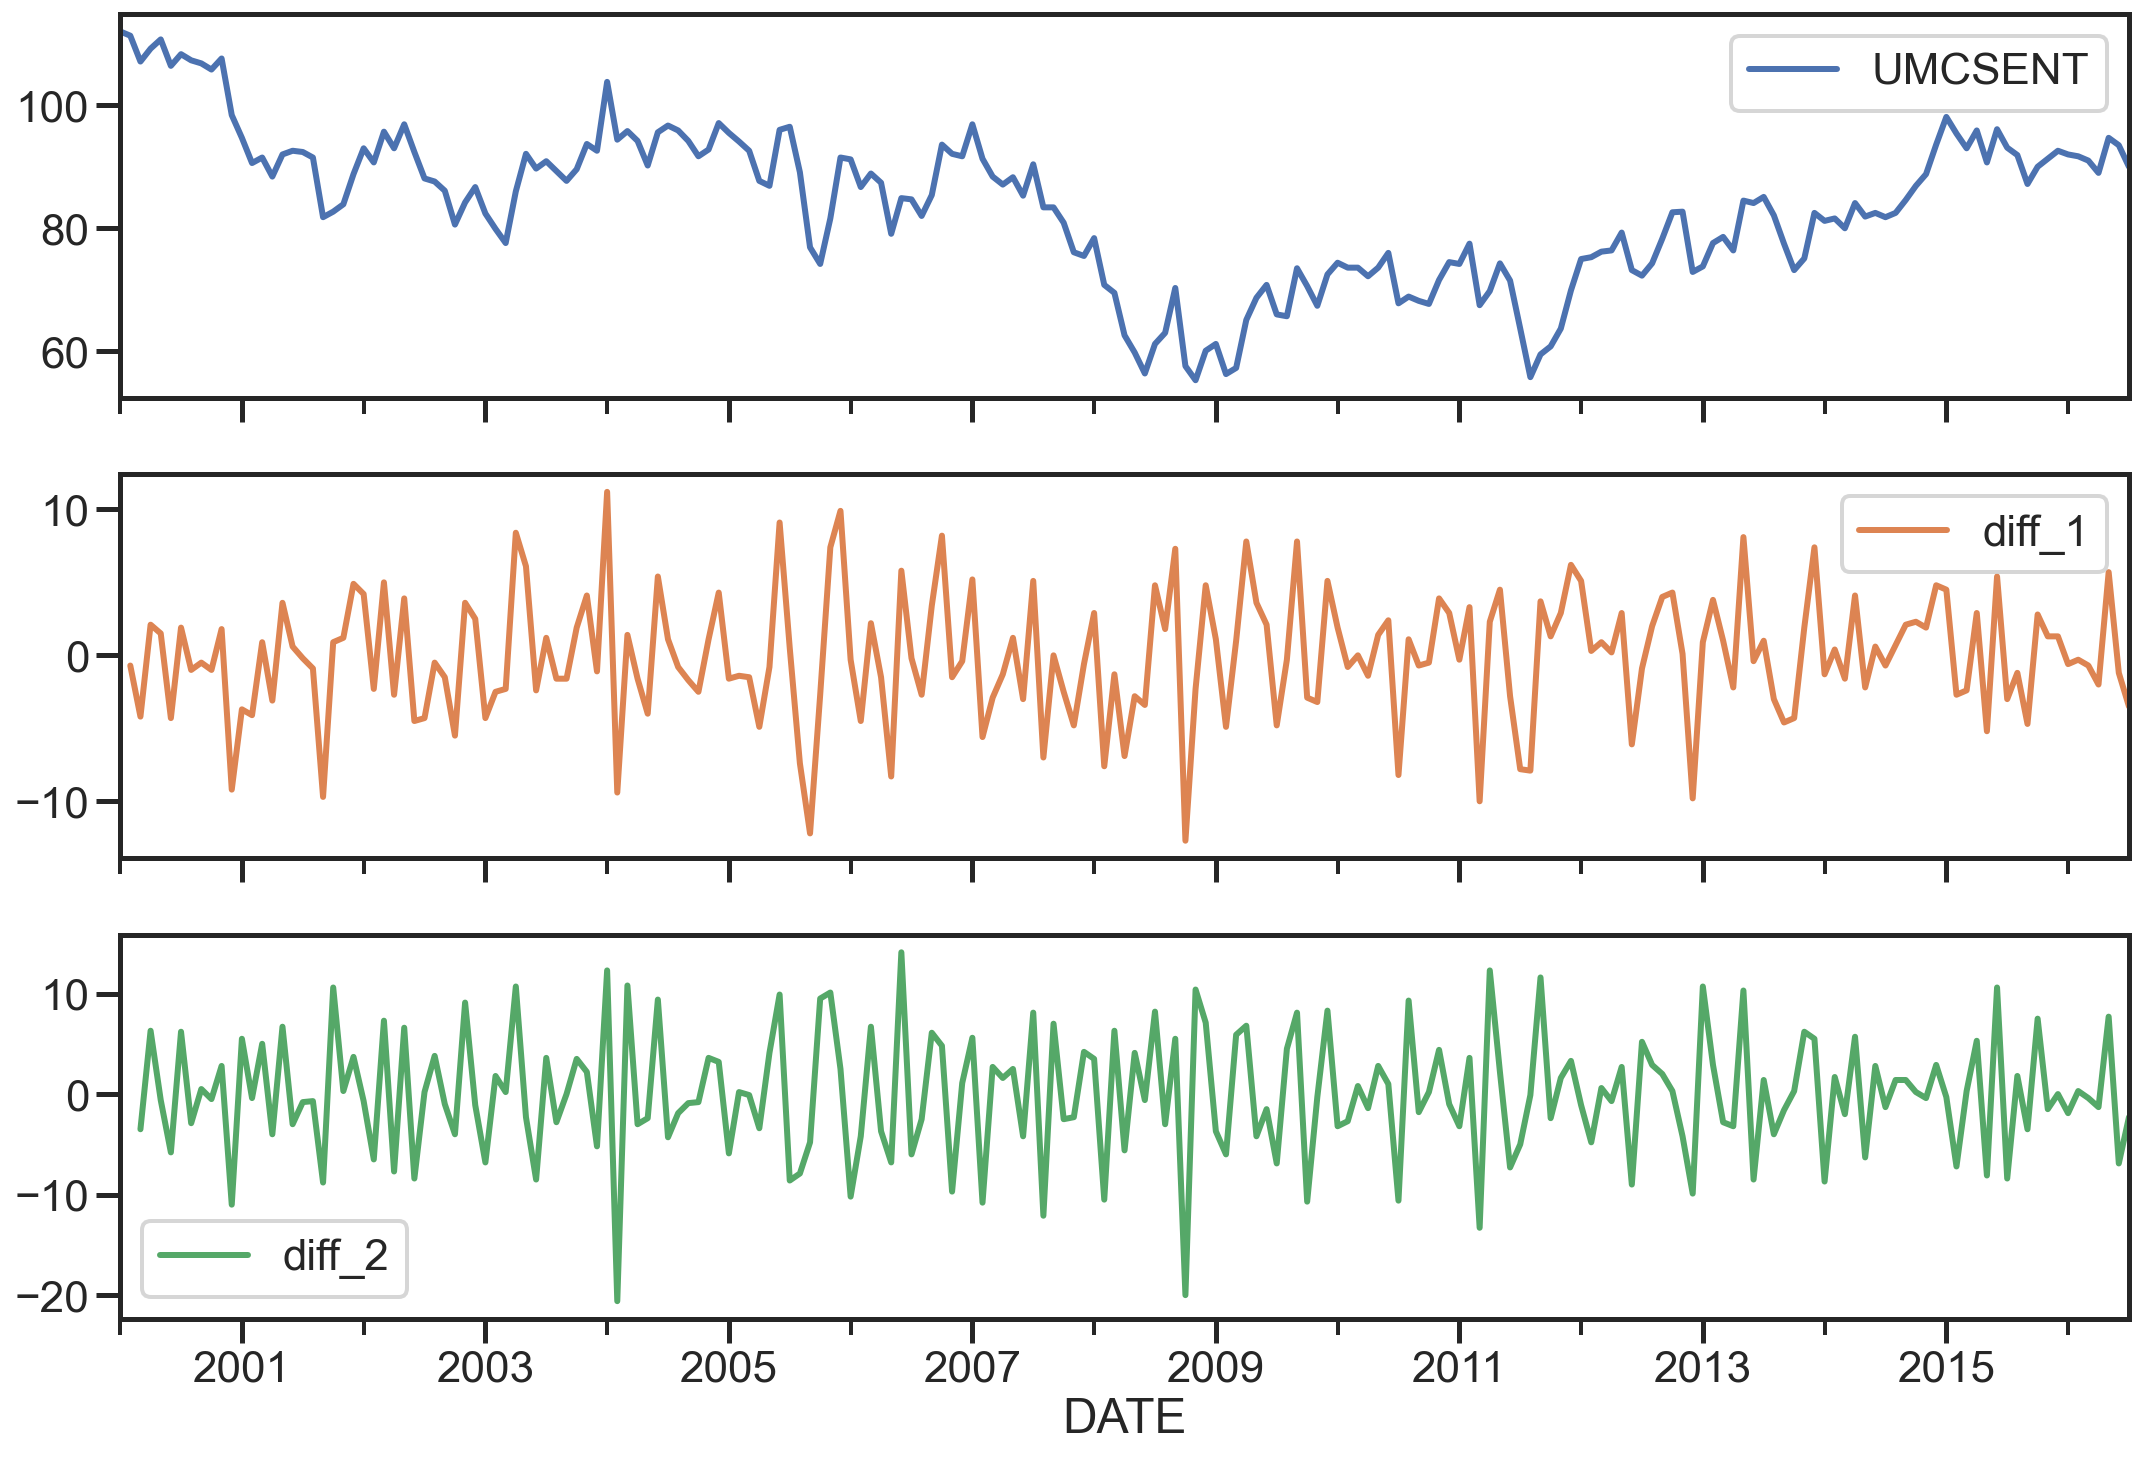

In [21]:
# 对时间序列进行差分，确认差分阶数d, 作用: 将序列平稳化
# 从图可以看到 一阶，二阶差分差不多，d取1即可;
# 一阶差分
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
# 二阶差分
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
sentiment_short.plot(subplots=True, figsize=(18,12))

### 4.p,q阶值确认
#### 4.1 ACF/PACF 数据预处理
因为ACF/PACF 只针对一维数据进行分析，而刚才给sentiment_short 添加'diff_1', 'diff_2' 两列使得sentiment_short 变成了三维数据，因为d值已经确认， 后面不再需要diff_1, diff_2 直接删除即可;

如果不删除直接ACF 则会报错: ValueError: x is required to have ndim 1 but has ndim 2

In [28]:
del sentiment_short['diff_1']
del sentiment_short['diff_2']

#### 4.2 绘制ACF和PACF图形

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


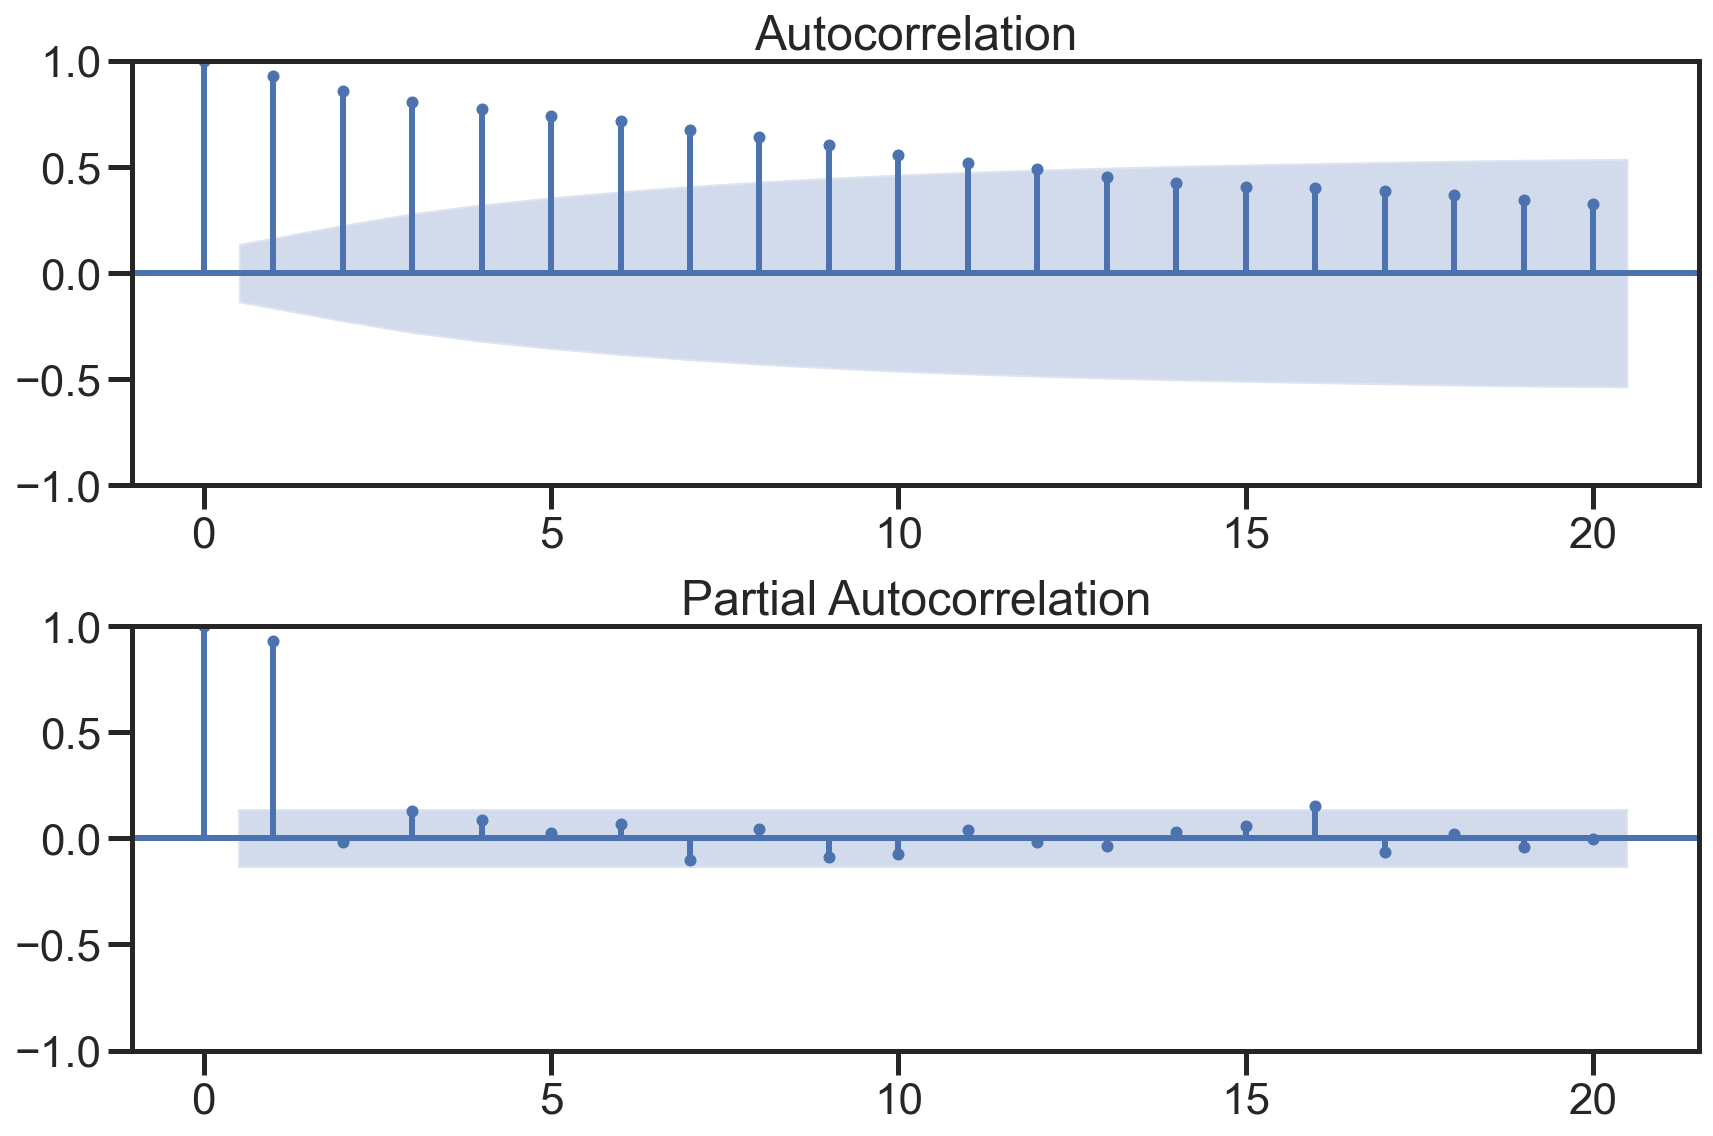

In [30]:
fig = plt.figure(figsize=(12,8))
#ACF 
ax1 = fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(sentiment_short,
                            lags=20, #lags表示滞后的阶数
                            ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#PACF
ax2 = fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(sentiment_short, lags=20,ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

 当铅垂线端点在蓝色区域外时，我们认为该ACF(k)显著。如果在k之后没有ACF(k)显著，则称该时间序列ACF k 阶截尾。如果一直有ACF(k)显著，则称该时间序列ACF 拖尾。
 
 - MA(q) ACF 11阶截尾
 - AR(p) PACF 1阶截尾

#### 4.3 残差图，直方图，ACF图和PACF图

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


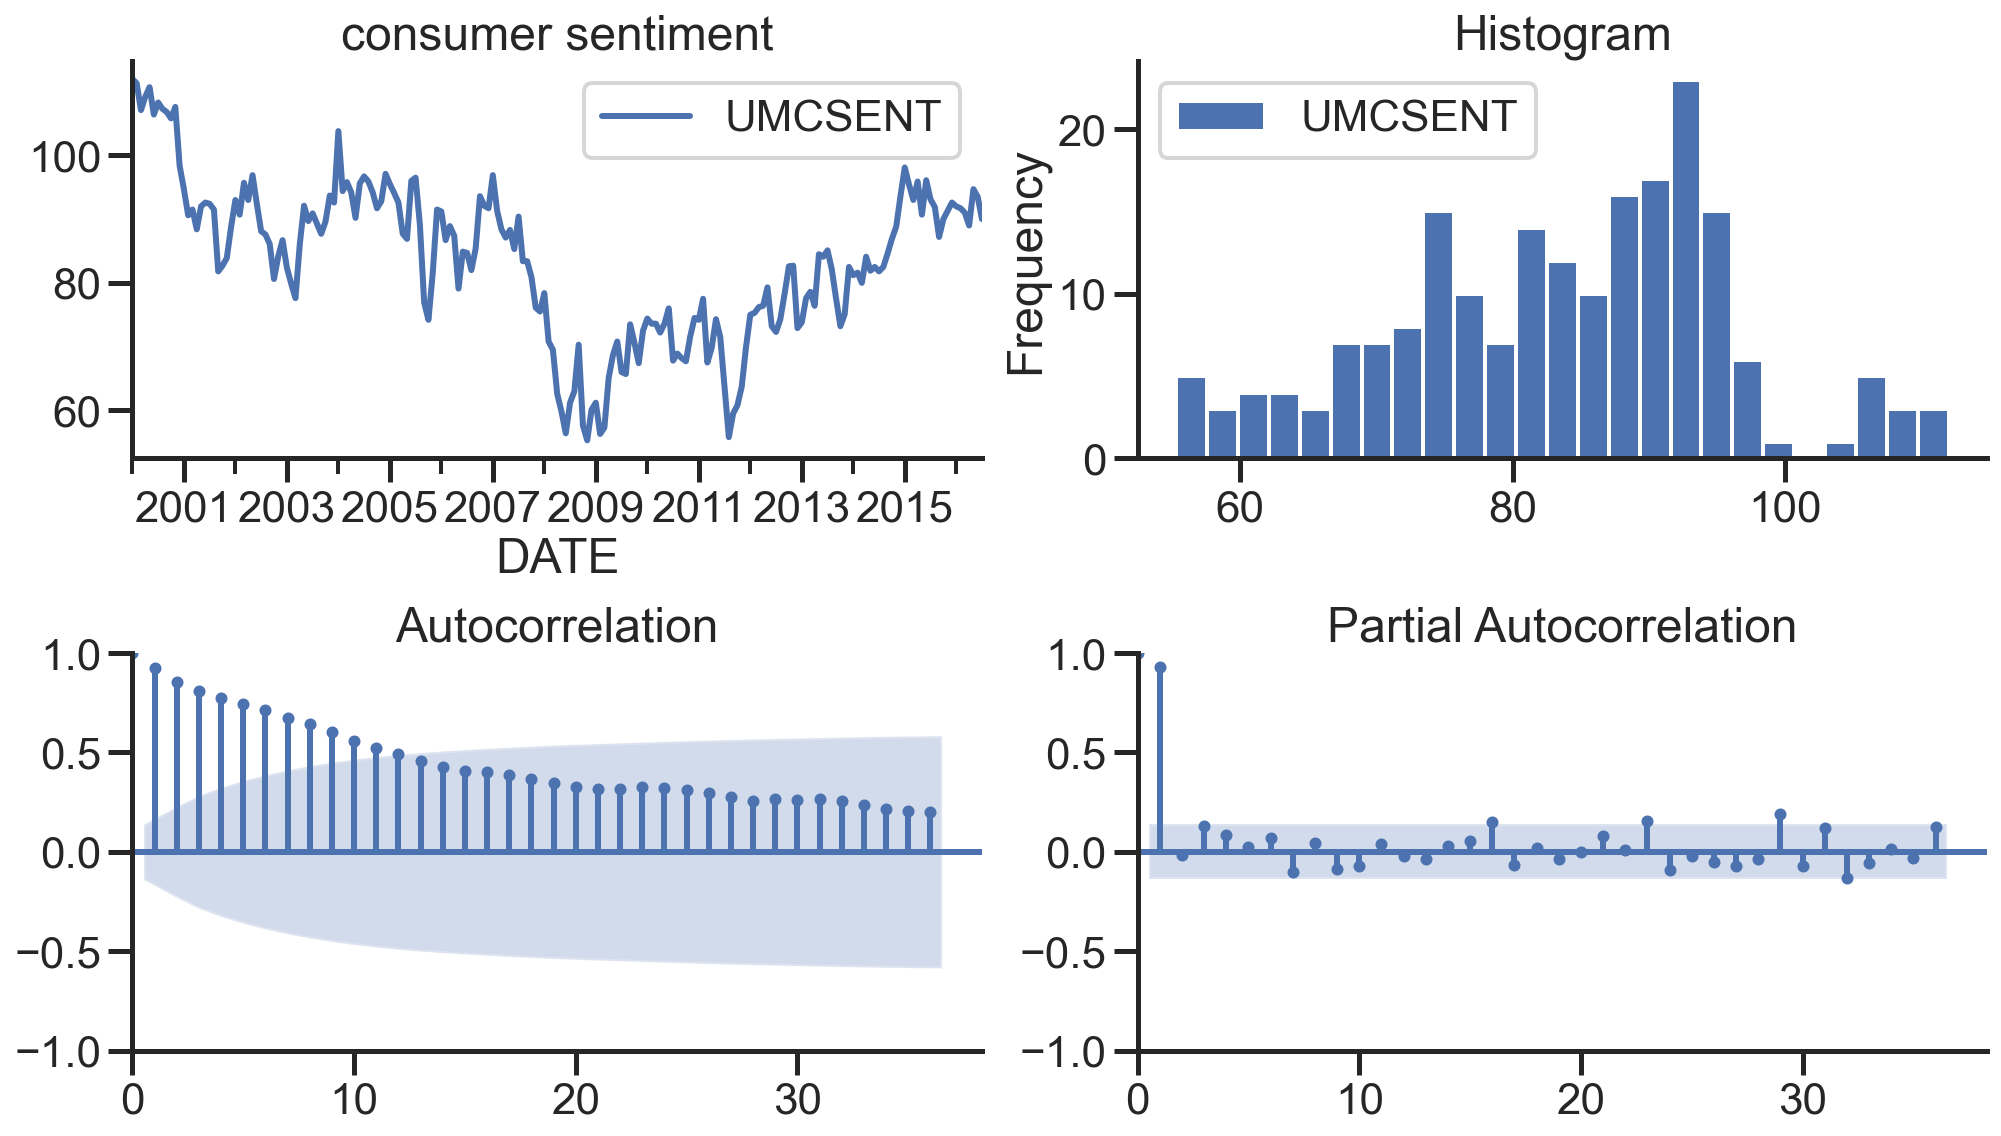

In [31]:
def tsplot(y, lags=None, title='', figsize=(14,8)):
    fig = plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine() 
    plt.tight_layout() 
    return ts_ax, hist_ax, acf_ax, pacf_ax
    
tsplot(sentiment_short, title='consumer sentiment', lags=36)
plt.show()

#### 关于ARMA通用判断标准说明如下表格
截尾：在大于某个常数k后快速趋于0为k阶截尾
拖尾：始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动)
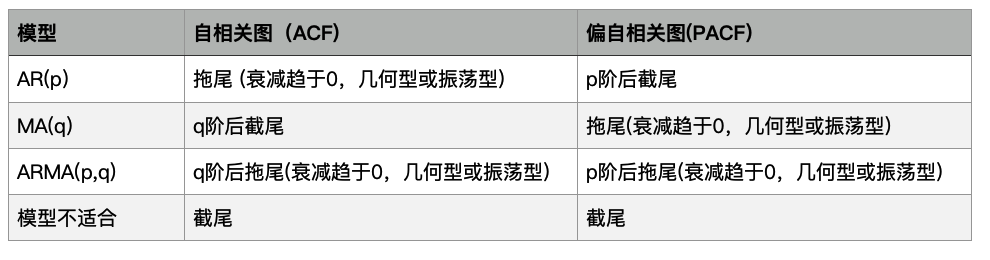

可以看出上面 ACF 是拖尾， PACF 是0阶后截尾， 所以适合AR(0) 模型